In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import os.path as osp
import pandas as pd

import torch
sys.path.insert(1, osp.abspath('../'))
torch.cuda.empty_cache()

## BoundingBoxDataset example

In [29]:
from modules.torch_dataset.bounding_box_dataset import BoundingBoxDataset

det_df = pd.read_csv("/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20/annotations/S01/c001/gt.txt")
ds = BoundingBoxDataset(det_df, 
                        frame_dir="/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20/frames/S01/c001",
                        frame_width=1080, 
                        frame_height=1920, 
                        output_size=(224, 224),
                        fully_qualified_dir=True,
                        pad_=False,
                        return_det_ids_and_frame=True,
                        mode='train',
                        augmentation=None)

In [30]:
from torch.utils.data import DataLoader  
bb_loader = DataLoader(ds, 
                        batch_size=32, 
                        pin_memory=True, 
                        num_workers=2)

In [31]:
frame_num, det_id, camera, sequence, bboxes = ds[0]

In [32]:
bboxes.permute(1,2,0).shape

torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


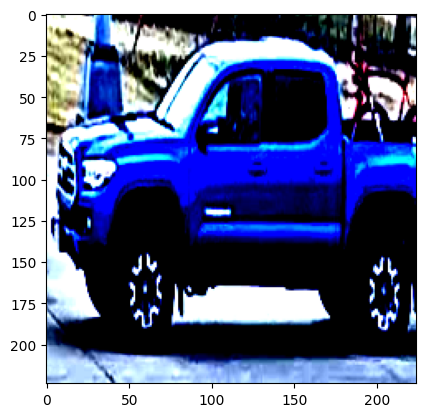

In [33]:
import matplotlib.pyplot as plt
plt.imshow(bboxes.permute(1,2,0))

## SequenceGraphDataset example

In [ ]:
from modules.torch_dataset.sequence_graph_dataset import SequenceGraphDataset

dataset = SequenceGraphDataset(sequence_path_prefix='datasets/AIC20', 
                               sequence_names=['S01', 'S03', 'S04'], 
                                annotations_filename='gt.txt')

data = dataset[0]     # Access the first processed graph

In [5]:
import pandas as pd
edge = pd.read_json("datasets/AIC20/logs/S03/sequence_graph_edges.json")
edge.head()

,src_node_id,dst_node_id,src_obj_id,dst_obj_id,edge_labels
0,0,14,252,252,1
1,0,15,252,242,0
2,0,16,252,256,0
3,0,17,252,246,0
4,0,18,252,247,0


In [37]:
edge[(edge.src_obj_id == edge.dst_obj_id)].head()

,src_node_id,dst_node_id,src_obj_id,dst_obj_id,edge_labels
0,0,14,252,252,1
17,0,31,252,252,1
31,0,45,252,252,1
48,0,62,252,252,1
67,1,15,242,242,1


## ObjectGraphDataset example

In [18]:
from models.reid.resnet import resnet101_ibn_a
model = resnet101_ibn_a(model_path="C:/Users/mejia/Documents/tfm/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth", device="cuda")

Loading pretrained model from C:/Users/mejia/Documents/tfm/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth


In [5]:
import torchvision.transforms.v2 as transforms
augmentation = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomErasing(scale=(0.02, 0.15)),
        transforms.RandomRotation(degrees=0.15),
        transforms.RandomPerspective(distortion_scale=0.25)
    ])

In [21]:
from modules.torch_dataset.object_graph_dataset import ObjectGraphDataset
from modules.data_processor.annotations_processor import AnnotationsProcessor
import numpy as np

data_df = AnnotationsProcessor(sequence_path='C:/Users/mejia/Documents/tfm/mcmt_gnn/datasets/AIC20', annotations_filename='gt.txt').consolidate_annotations(['S02'], ["frame", "camera"])
ids = np.random.choice(data_df.id.unique(), 20)
data_df = data_df[data_df.id.isin(ids)]

dataset = ObjectGraphDataset(data_df, 
                             sequence_path_prefix="C:/Users/mejia/Documents/tfm/mcmt_gnn/datasets/AIC20", 
                             reid_model=model,
                             num_ids_per_graph=-1, 
                             embeddings_per_it=200, 
                             resized_img_shape=(224, 224), 
                             augmentation=None,
                             return_dataframes=False)

Sampling object ids


In [22]:
data = dataset[0]

Computing embeddings


100%|██████████| 13/13 [00:24<00:00,  1.91s/it]

Generating nodes
Generating edges
Creating PyG graph


In [23]:
data.y

tensor([ 97, 107, 127, 138, 144, 151, 158, 172, 185, 189, 213, 222, 223, 237,
         97, 107, 138, 147, 158, 172, 185, 186, 213, 222, 237, 127, 138, 144,
        147, 151, 172, 173, 185, 189, 223, 237,  97, 107, 127, 144, 147, 151,
        158, 172, 173, 185, 186, 189, 213, 223, 237], device='cuda:0')

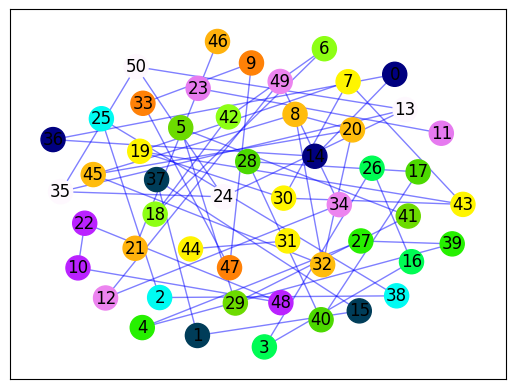

In [25]:
from torch_geometric.utils.convert import to_networkx, from_networkx
from modules.torch_dataset.utils import draw_pyg_network
import networkx as nx
draw_pyg_network(data, [1], layout='spring')

## ObjectGraphDataset with negative sampling

In [93]:
from models.reid.resnet import resnet101_ibn_a
model = resnet101_ibn_a(model_path="/Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth", device="cpu")

Loading pretrained model from /Users/hectormejia/Documents/TFM/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth


In [116]:
from modules.torch_dataset.object_graph_dataset import ObjectGraphDataset
from modules.data_processor.annotations_processor import AnnotationsProcessor
import numpy as np


dataset = ObjectGraphDataset(data_df, 
                             sequence_path_prefix="/Users/hectormejia/Documents/TFM/mcmt_gnn/datasets/AIC20", 
                             sequence_names=['S02'], 
                             annotations_filename='gt.txt', 
                             reid_model=model,
                             num_ids_per_graph=-1, 
                             embeddings_per_it=48, 
                             resized_img_shape=(224, 224), 
                             orignal_img_shape=(1920, 1080), 
                             negative_sampling=True,
                             augmentation=None,
                             return_dataframes=False)

Sampling object ids


In [117]:
data = dataset[0] 

Computing embeddings


100%|██████████| 55/55 [09:18<00:00, 10.15s/it]

Generating nodes
Generating edges
Creating PyG graph


In [213]:
from modules.torch_dataset.utils import draw_pyg_network

draw_pyg_network(data, [ 1])

AttributeError: 'tuple' object has no attribute 'edge_index'

## Testing post-processing

In [3]:
from modules.torch_dataset.object_graph_dataset import ObjectGraphDataset
from modules.data_processor.annotations_processor import AnnotationsProcessor
import numpy as np

data_df = AnnotationsProcessor(sequence_path='C:/Users/mejia/Documents/tfm/mcmt_gnn/datasets/AIC20', annotations_filename='gt_filtered.txt').consolidate_annotations(['S02'], ["frame", "camera"])


In [4]:
gt_df = AnnotationsProcessor(sequence_path='C:/Users/mejia/Documents/tfm/mcmt_gnn/datasets/AIC20', annotations_filename='gt_filtered.txt').consolidate_annotations(['S02'], ["frame", "camera"])


In [5]:
from models.reid.resnet import resnet101_ibn_a
model = resnet101_ibn_a(model_path="C:/Users/mejia/Documents/tfm/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth", device="cuda")

Loading pretrained model from C:/Users/mejia/Documents/tfm/mcmt_gnn/models/reid/resnet101_ibn_a_2.pth


In [7]:
from modules.torch_dataset.object_graph_dataset import ObjectGraphDataset
import numpy as np
import torch_geometric.transforms as T

dataset = ObjectGraphDataset(data_df, 
                             sequence_path_prefix="C:/Users/mejia/Documents/tfm/mcmt_gnn/datasets/AIC20", 
                             reid_model=model,
                             num_ids_per_graph=-1, 
                             embeddings_per_it=150, 
                             frames_per_vehicle_cam=10,
                             resized_img_shape=(384, 384), 
                             augmentation=None,
                             return_dataframes=True,
                             frames_num_workers=1,
                             graph_transform=T.ToUndirected())
data = dataset[0] 

Sampling object ids
Computing embeddings


100%|██████████| 28/28 [01:45<00:00,  3.76s/it]


Generating nodes
Generating edges
Creating PyG graph


In [15]:
import yaml
with open("C:/Users/mejia/Documents/tfm/mcmt_gnn/config/training_rgcnn.yml", "r") as config_file:
    config = yaml.safe_load(config_file)
    gnn_arch = config["gnn_arch"]

In [16]:
import torch
from models.mcmt.rgnn import MOTMPNet
model_state = torch.load("C:/Users/mejia/Documents/tfm/mcmt_gnn/models/mcmt/best.pth.tar", map_location=torch.device('cuda'))

model = MOTMPNet(gnn_arch).to("cuda")
model.load_state_dict(model_state['model_state_dict'])

<All keys matched successfully>

In [17]:
data_df['id_old'] = data_df.id
#data_df['id'] = 0

In [18]:
import torch
from modules.inference.postprocessing import postprocessing, remove_dets_with_one_camera
from modules.inference.preprocessing import remove_non_roi, filter_dets_outside_frame_bounds
import torch.nn.functional as F

# Batches from our custom datasets return these vars
graph, node_df, _, _ = data

with torch.no_grad():
    # Output predictions from GNN            
    output_dict, _ = model(graph.to("cuda"))
    logits = output_dict['classified_edges'][0]
    preds_prob = F.softmax(logits, dim=1).cpu() #torch.nn.functional.one_hot(graph.edge_labels).cpu()
    predictions = torch.argmax(logits, dim=1).cpu() #graph.edge_labels.cpu() #

# Connected components output
id_pred, predictions = postprocessing(4, 
                                    preds_prob,
                                    predictions,
                                    graph.edge_index.cpu().numpy(),
                                    graph.cpu(),
                                    True, False)

# Generate tracking dataframe
for n in range(len(graph.x)):
    id_new = int(id_pred[n])
    cam_id = node_df.camera[n]
    id_old = node_df.object_id[n]

    # Assign the labels from the connected components to the detections df
    data_df.loc[(data_df['id_old'] == id_old) & 
                    (data_df['camera'] == cam_id),'id'] = id_new

# If required, remove detections that go beyond the frame limits
data_df = filter_dets_outside_frame_bounds(data_df, 1920, 1080)
gt_df = filter_dets_outside_frame_bounds(gt_df, 1920, 1080)

#print(len(data_df))
data_df = remove_dets_with_one_camera(data_df)

#print(len(data_df))
#data_df = remove_non_roi("C:/Users/mejia/Documents/tfm/mcmt_gnn/datasets/AIC20", data_df)

c:\Users\mejia\Documents\tfm\mcmt_gnn\modules\inference\postprocessing.py:343: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return id_pred, torch.tensor(whole_edges_prediction)


In [19]:
from sklearn.metrics import classification_report
print(classification_report(graph.edge_labels.cpu(), predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    149456
           1       0.88      0.82      0.84       998

    accuracy                           1.00    150454
   macro avg       0.94      0.91      0.92    150454
weighted avg       1.00      1.00      1.00    150454



In [20]:
import motmetrics as mm
from modules.inference.postprocessing import fix_annotation_frames
data_df.camera = data_df.camera.apply(lambda cam: int(cam.replace('c', '')))
gt_df.camera = gt_df.camera.apply(lambda cam: int(cam.replace('c', '')))

gt_df, pred_df = fix_annotation_frames(gt_df, data_df)

# Setting column names as motmetrics requires it
gt_df = gt_df.rename(columns={'frame': 'FrameId',
                            'xmin': 'X', 
                            'ymin': 'Y', 
                            'width': 'Width', 
                            'height': 'Height',
                            'id': 'Id'})

pred_df = pred_df.rename(columns={'frame': 'FrameId',
                            'xmin': 'X', 
                            'ymin': 'Y', 
                            'width': 'Width', 
                            'height': 'Height',
                            'id': 'Id'})

# Setting frame id and id as index since motmetrics requires it
gt_df = gt_df.set_index(['FrameId', 'Id'])
pred_df = pred_df.set_index(['FrameId', 'Id'])

# Compute metrics using Pymotmetrics
mh = mm.metrics.create()
accumulator = mm.utils.compare_to_groundtruth(gt_df, pred_df, 'iou', distth=0.7)
metrics=[*mm.metrics.motchallenge_metrics, *['num_frames','idfp','idfn','idtp']]
summary = mh.compute(accumulator, metrics=metrics, name='MultiCam')


In [21]:
summary

,idf1,idp,idr,recall,precision,num_unique_objects,mostly_tracked,partially_tracked,mostly_lost,num_false_positives,...,num_fragmentations,mota,motp,num_transfer,num_ascend,num_migrate,num_frames,idfp,idfn,idtp
MultiCam,0.931288,0.975575,0.890847,0.913151,1.0,145,128,10,7,0,...,7,0.912941,0.0,12,1,9,7316,424.0,2075.0,16935.0


## ObjectGraphREIDPrecompDataset test

In [3]:
from modules.torch_dataset.object_graph_reid_precomp import ObjectGraphREIDPrecompDataset
import numpy as np
import torch_geometric.transforms as T

ds = ObjectGraphREIDPrecompDataset(sequence_path_prefix="/home/hmv/tfm/mcmt_gnn/datasets/AIC20",
                                   sequence_names=["S02"],
                                   annotations_filename='gt.txt',
                                   num_ids_per_graph=5,
                                   return_dataframes=True,
                                   graph_transform=None)


In [4]:
graph, node_df, edge_df = ds[0]

In [5]:
graph

Data(x=[15, 2048], edge_index=[2, 83], edge_attr=[83, 2], y=[15], edge_labels=[83])

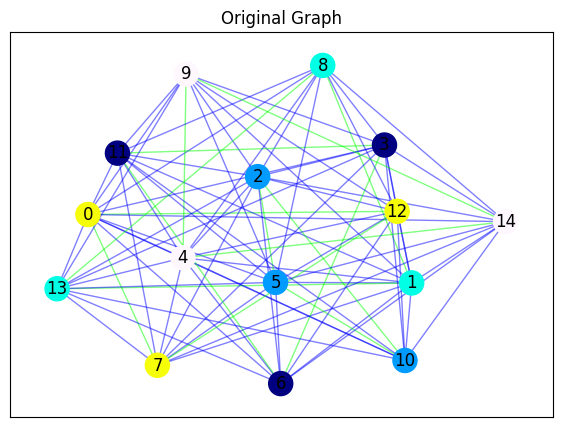

In [15]:
from modules.plots import draw_pyg_network
draw_pyg_network(graph.cpu(), "Original Graph", class_ids=[0, 1], layout='spring', show=False, figsize=(7,5))

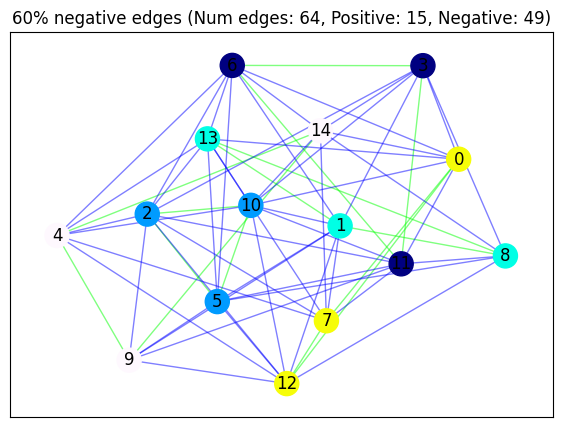

In [24]:
from modules.torch_dataset.utils import simple_negative_sampling
import torch
edge_idx = graph.edge_index
edge_labels = graph.edge_labels
graph_60 = graph.__copy__()
sampled_edge_df, graph_60.edge_index, graph_60.edge_labels = simple_negative_sampling(edge_df, edge_idx.T, edge_labels, negative_ratio=0.6)
graph_60.edge_index = torch.tensor(graph_60.edge_index.T)
graph_60.edge_labels = torch.tensor(graph_60.edge_labels)
num_pos = len(graph_60.edge_labels[graph_60.edge_labels == 1])
num_neg = len(graph_60.edge_labels[graph_60.edge_labels == 0])
total_edges = len(graph_60.edge_labels)
draw_pyg_network(graph_60.cpu(), f"60% negative edges (Num edges: {total_edges}, Positive: {num_pos}, Negative: {num_neg})", class_ids=[0, 1], layout='spring', show=False, figsize=(7,5))

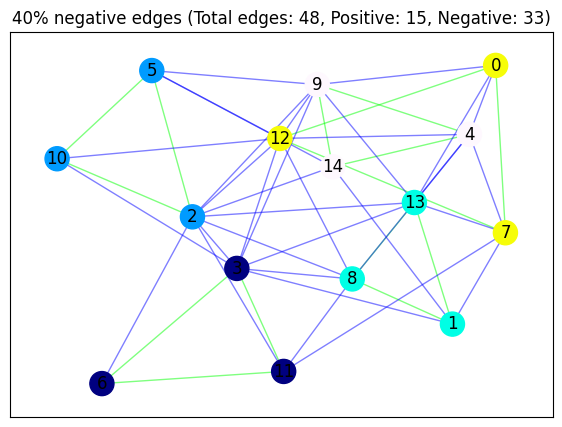

In [26]:
from modules.torch_dataset.utils import simple_negative_sampling
import torch
edge_idx = graph.edge_index
edge_labels = graph.edge_labels
graph_60 = graph.__copy__()
sampled_edge_df, graph_60.edge_index, graph_60.edge_labels = simple_negative_sampling(edge_df, edge_idx.T, edge_labels, negative_ratio=0.4)
graph_60.edge_index = torch.tensor(graph_60.edge_index.T)
graph_60.edge_labels = torch.tensor(graph_60.edge_labels)
num_pos = len(graph_60.edge_labels[graph_60.edge_labels == 1])
num_neg = len(graph_60.edge_labels[graph_60.edge_labels == 0])
total_edges = len(graph_60.edge_labels)
draw_pyg_network(graph_60.cpu(), f"40% negative edges (Total edges: {total_edges}, Positive: {num_pos}, Negative: {num_neg})", class_ids=[0, 1], layout='spring', show=False, figsize=(7,5))

In [4]:
from modules.torch_dataset.object_graph_gallery_precomp import ObjectGraphGalleryPrecompDataset
import numpy as np
import torch_geometric.transforms as T
ds = ObjectGraphGalleryPrecompDataset(sequence_path_prefix="/home/hmv/tfm/mcmt_gnn/datasets/AIC20",
                                sequence_names=["S02"],
                                annotations_filename='gt.txt',
                                num_ids_per_graph=-1,
                                return_dataframes=True,
                                graph_transform=T.ToUndirected())

In [5]:
graph, node_df, edge_df = ds[0]

In [27]:
ids = torch.unique(graph.y)[:5]
sample_data = graph.x[torch.isin(graph.y, ids)]
sample_ids = graph.y[torch.isin(graph.y, ids)]

In [28]:
flattened_data = sample_data.view(-1, 2048).cpu().numpy()
sample_ids = np.repeat(sample_ids.cpu().numpy(), 20)

/tmp/ipykernel_458813/1791584452.py:22: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=sample_ids, cmap='viridis')
/home/hmv/anaconda3/envs/mcmt_gnn/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


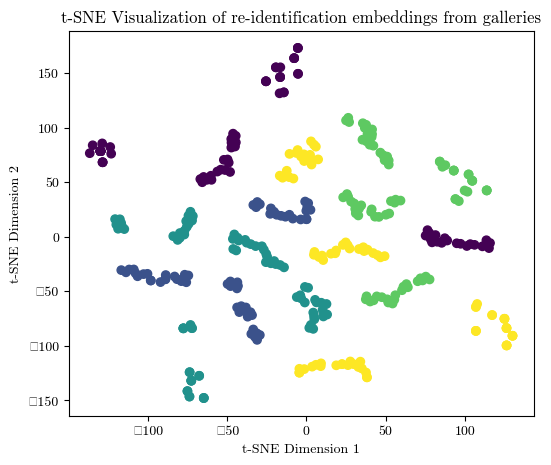

In [35]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Set the default font to Computer Modern Serif
# Use a built-in font similar to LaTeX
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

# Assuming your tensor is named 'data_tensor' and has size (19, 20, 2048)
# Assuming your tensor of IDs is named 'ids_tensor' and has size (19,)
# Make sure to replace these names with your actual tensor names

# Reduce the dimensionality to 2 using t-SNE with lower perplexity
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embedded_data = tsne.fit_transform(flattened_data)

# Plot the data using matplotlib
plt.figure(figsize=(6, 5))

# Scatter plot with different colors for each ID
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=sample_ids, cmap='viridis')

# Set plot labels
plt.title('t-SNE Visualization of re-identification embeddings from galleries')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Show the plot
plt.show()

In [19]:
flattened_data = torch.mean(sample_data, dim=1).cpu().numpy()
sample_ids = graph.y[torch.isin(graph.y, ids)].cpu().numpy()

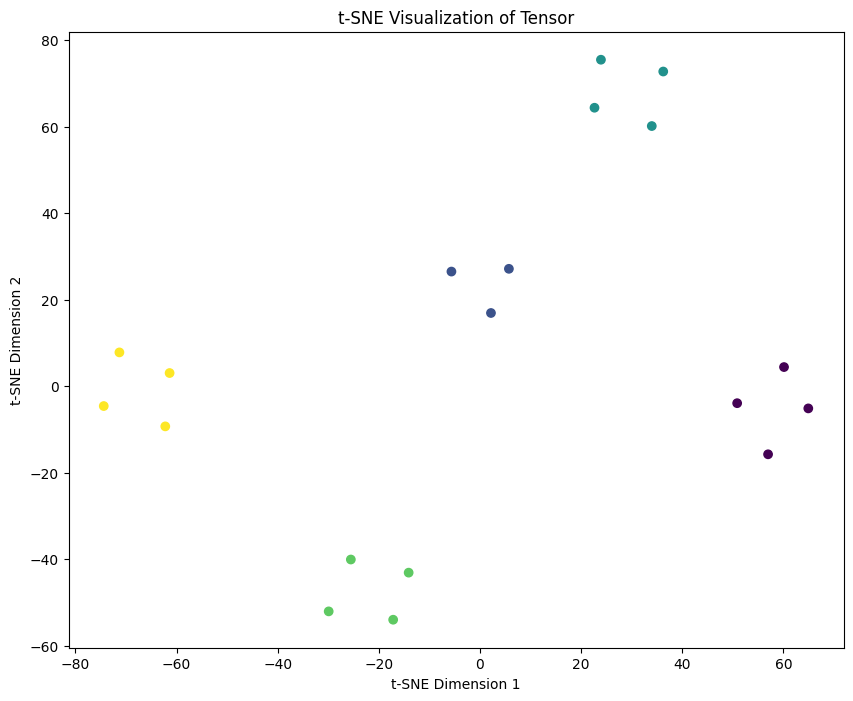

In [20]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming your tensor is named 'data_tensor' and has size (19, 20, 2048)
# Assuming your tensor of IDs is named 'ids_tensor' and has size (19,)
# Make sure to replace these names with your actual tensor names

# Reduce the dimensionality to 2 using t-SNE with lower perplexity
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embedded_data = tsne.fit_transform(flattened_data)

# Plot the data using matplotlib
plt.figure(figsize=(10, 8))

# Scatter plot with different colors for each ID
scatter = plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=sample_ids, cmap='viridis')

# Set plot labels
plt.title('t-SNE Visualization of Tensor')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Show the plot
plt.show()